https://www.datacamp.com/tutorial/complete-guide-data-augmentation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers
import keras

we will be using the “cats_vs_dogs” dataset. The dataset size is 786.68 MiB, and we will apply various image augmentation and train the binary classifier.

In the code below, we have loaded 80% training, 10% validation, and a 10% test set with labels and metadata.

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.AV1ROI_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


There are two classes in the dataset ‘cat’ and ‘dog’.

In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


We will use iterators to extract only four random images with labels from the training set and display them using the matplotlib `.imshow()` function.

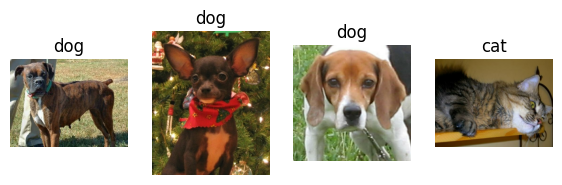

In [4]:
get_label_name = metadata.features['label'].int2str
train_iter = iter(train_ds)
fig = plt.figure(figsize=(7, 8))
for x in range(4):
  image, label = next(train_iter)
  fig.add_subplot(1, 4, x+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(get_label_name(label));

we are resizing and rescaling the image using Keras Sequential and image augmentation layers. We will first resize the image to 180X180 and then rescale it by 1/255.

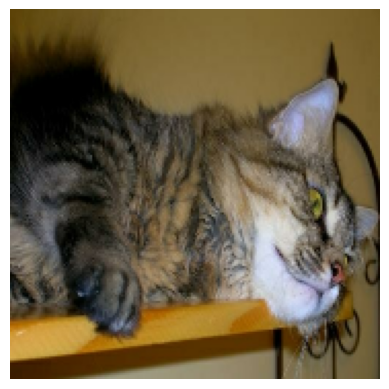

In [5]:
IMG_SIZE = 180

resize_and_rescale = keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.axis('off')
plt.imshow(result);

apply random flip and rotation to the same image. We will use loop, subplot, and imshow to display six images with random geometric augmentation.

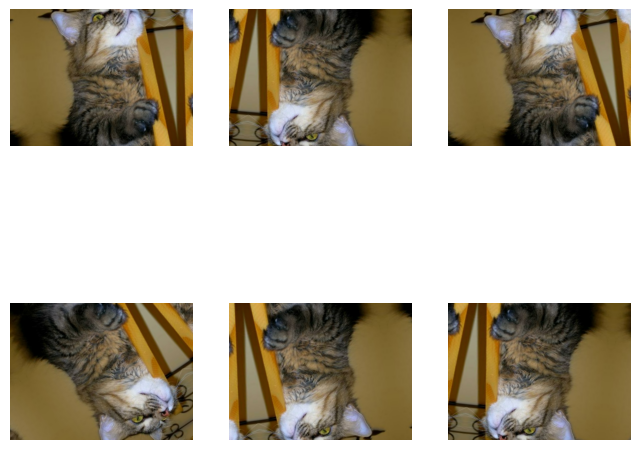

In [6]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])


plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")

There are two ways to apply augmentation to the images. The first method is by directly adding the augmentation layers to the model.

In [7]:
model = keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  # Add the model layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

The second method is to apply the data augmentation to the entire train set using Dataset.map

In [8]:
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

create a data preprocessing function to process train, valid, and test sets.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

# Ensure resize_and_rescale and data_augmentation are defined correctly
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
])

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Apply resize and rescale to all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)  # Shuffle only if needed, typically for training

    # Batch the datasets
    ds = ds.batch(batch_size)

    if augment:
        # Apply data augmentation only to the training set
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # Use prefetch to optimize performance
    return ds.prefetch(buffer_size=AUTOTUNE)

# Prepare datasets
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

create a simple model with convolution and dense layers. Make sure the input shape is similar to the image shape

In [11]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(180,180,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1,activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


compile the model and train it for one epoch. The optimizer is Adam, the loss function is Binary Cross Entropy, and the metric is accuracy

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


582/582 ━━━━━━━━━━━━━━━━━━━━ 116s 183ms/step - accuracy: 0.4916 - loss: 1.2336 - val_accuracy: 0.5185 - val_loss: 0.6932


In [13]:
loss, acc = model.evaluate(test_ds)

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4831 - loss: 0.6931
